In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

In [ ]:
pip install kaggle

In [ ]:
! pip install -q kaggle
import os
if not os.path.isfile(os.path.expanduser('~/.kaggle/kaggle.json')):
  from google.colab import files
  print("Upload kaggle.json here")
  files.upload()

if not os.path.isfile('IMDB Dataset.csv'):
  !mkdir ~/.kaggle
  !mv ./kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  dataset_name = 'sartajbhuvaji/brain-tumor-classification-mri'
  zip_name = dataset_name.split('/')[-1]

  !kaggle datasets download -d {dataset_name}
  !unzip -q ./{zip_name}.zip -d .


Upload kaggle.json here


TypeError: ignored

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
image_size = 150
target_per_class = 1500

X_train = []
y_train = []

# Define an ImageDataGenerator with data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Loop through each class
for i in labels:
    folderPath = os.path.join('/content', 'Training', i)

    # Count the current number of images in the class
    current_count = 0

    # Loop through the images in the class
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))

        # Apply data augmentation and add augmented images
        for _ in range(5):  # Apply augmentation 5 times per image to reach the target
            augmented_img = datagen.random_transform(img)
            X_train.append(augmented_img)
            y_train.append(i)
            current_count += 1

            # Stop when the target number of images is reached for this class
            if current_count >= target_per_class:
                break

    # Fill the class with additional copies of existing images if needed
    while current_count < target_per_class:
        for j in range(len(X_train)):
            if y_train[j] == i:
                img = X_train[j]
                X_train.append(img)
                y_train.append(i)
                current_count += 1
                if current_count >= target_per_class:
                    break

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 827/827 [00:15<00:00, 52.82it/s] 


In [ ]:
len(X_train)

7670

In [ ]:
for label in labels:
    count = np.sum(y_train == label)
    print(f"Class '{label}' has {count} images.")

Class 'glioma_tumor' has 2026 images.
Class 'no_tumor' has 1595 images.
Class 'meningioma_tumor' has 2022 images.
Class 'pituitary_tumor' has 2027 images.


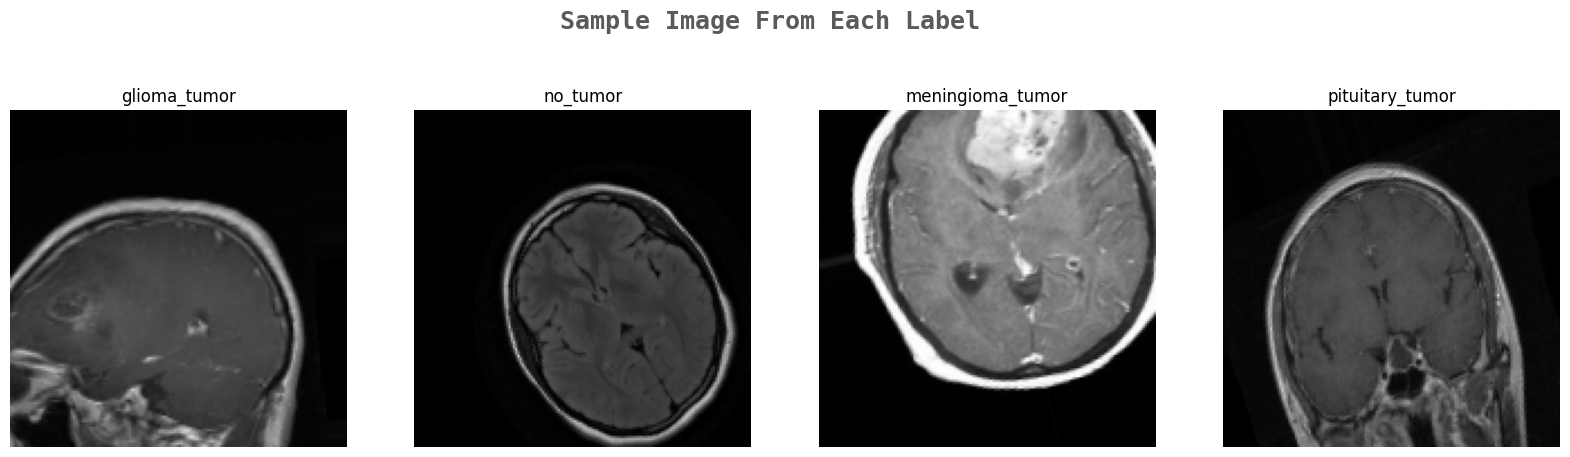

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1


In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(7670, 150, 150, 3)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
from tensorflow.keras.applications import DenseNet121
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
model = densenet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=densenet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 156, 156, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 75, 75, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1/conv[0][0]']      

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15
173/173 [==============================] - ETA: 0s - loss: 0.5833 - accuracy: 0.8104
Epoch 1: val_accuracy improved from -inf to 0.47394, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


173/173 [==============================] - 1769s 10s/step - loss: 0.5833 - accuracy: 0.8104 - val_loss: 5.6671 - val_accuracy: 0.4739 - lr: 0.0010
Epoch 2/15
173/173 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.9062
Epoch 2: val_accuracy improved from 0.47394 to 0.59121, saving model to effnet.h5
173/173 [==============================] - 1645s 9s/step - loss: 0.2741 - accuracy: 0.9062 - val_loss: 1.2483 - val_accuracy: 0.5912 - lr: 0.0010
Epoch 3/15
173/173 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9292
Epoch 3: val_accuracy improved from 0.59121 to 0.73779, saving model to effnet.h5
173/173 [==============================] - 1568s 9s/step - loss: 0.2067 - accuracy: 0.9292 - val_loss: 0.8337 - val_accuracy: 0.7378 - lr: 0.0010
Epoch 4/15
173/173 [==============================] - ETA: 0s - loss: 0.1666 - accuracy: 0.9395
Epoch 4: val_accuracy did not improve from 0.73779
173/173 [==============================] - 1535s 9s/step -

In [ ]:
model.save("brain.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


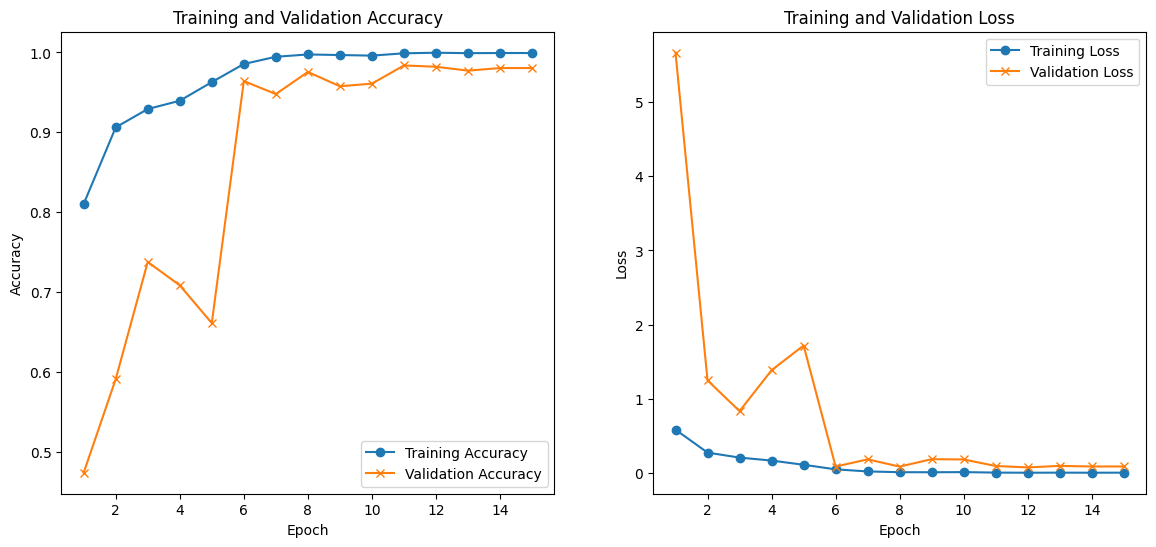

In [ ]:
import matplotlib.pyplot as plt

# Extracting metrics from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Generate list of epoch numbers
epochs = range(1, len(train_acc) + 1)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot accuracy
ax1.plot(epochs, train_acc, label='Training Accuracy', marker='o')
ax1.plot(epochs, val_acc, label='Validation Accuracy', marker='x')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(epochs, train_loss, label='Training Loss', marker='o')
ax2.plot(epochs, val_loss, label='Validation Loss', marker='x')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Show the plots
plt.show()


In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

48/48 [==============================] - 88s 2s/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       406
           1       0.97      0.99      0.98       314
           2       0.95      0.97      0.96       384
           3       1.00      0.98      0.99       430

    accuracy                           0.98      1534
   macro avg       0.97      0.98      0.98      1534
weighted avg       0.98      0.98      0.98      1534



In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)

# Assuming y_test is one-hot encoded, if it's not, you don't need the next line
y_test_new = np.argmax(y_test, axis=1)

# Calculate the accuracy
test_accuracy = accuracy_score(y_test_new, pred)

# Print the accuracy
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

48/48 [==============================] - 92s 2s/step
Testing Accuracy: 97.52%


In [ ]:
from tensorflow.keras.models import load_model

# Replace 'brain.h5' with the actual model file name
model = load_model('/content/brain.h5')


In [ ]:
import cv2
import numpy as np
# Load and preprocess the image for prediction
image_path = '/content/Training/meningioma_tumor/m3 (202).jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (150, 150))  # Resize the image to match the input shape of the model
image = np.expand_dims(image, axis=0)  # Add an extra dimension for batch size

# Make predictions
predictions = model.predict(image)
print(predictions)
# Assuming the model outputs probabilities for different classes
print("Predictions:", np.argmax(predictions))


1/1 [==============================] - 0s 146ms/step
[[1.2034530e-08 4.5189158e-10 9.9999928e-01 6.8947082e-07]]
Predictions: 2
